In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

# Loading the dataset
df = pd.read_csv('Housing.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

Dataset Shape: (545, 13)

First few rows:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Rang

In [2]:
# Data Preprocessing

# Convert categorical variables to numerical
categorical_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
                      'airconditioning', 'prefarea', 'furnishingstatus']

# Convert yes/no to 1/0
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
                'airconditioning', 'prefarea']

for col in binary_columns:
    df[col] = df[col].map({'yes': 1, 'no': 0})

# Handle furnishingstatus with one-hot encoding
df = pd.get_dummies(df, columns=['furnishingstatus'], prefix='furnishing')

print("After preprocessing - Dataset shape:", df.shape)
print("\nColumns after encoding:")
print(df.columns.tolist())

After preprocessing - Dataset shape: (545, 15)

Columns after encoding:
['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishing_furnished', 'furnishing_semi-furnished', 'furnishing_unfurnished']


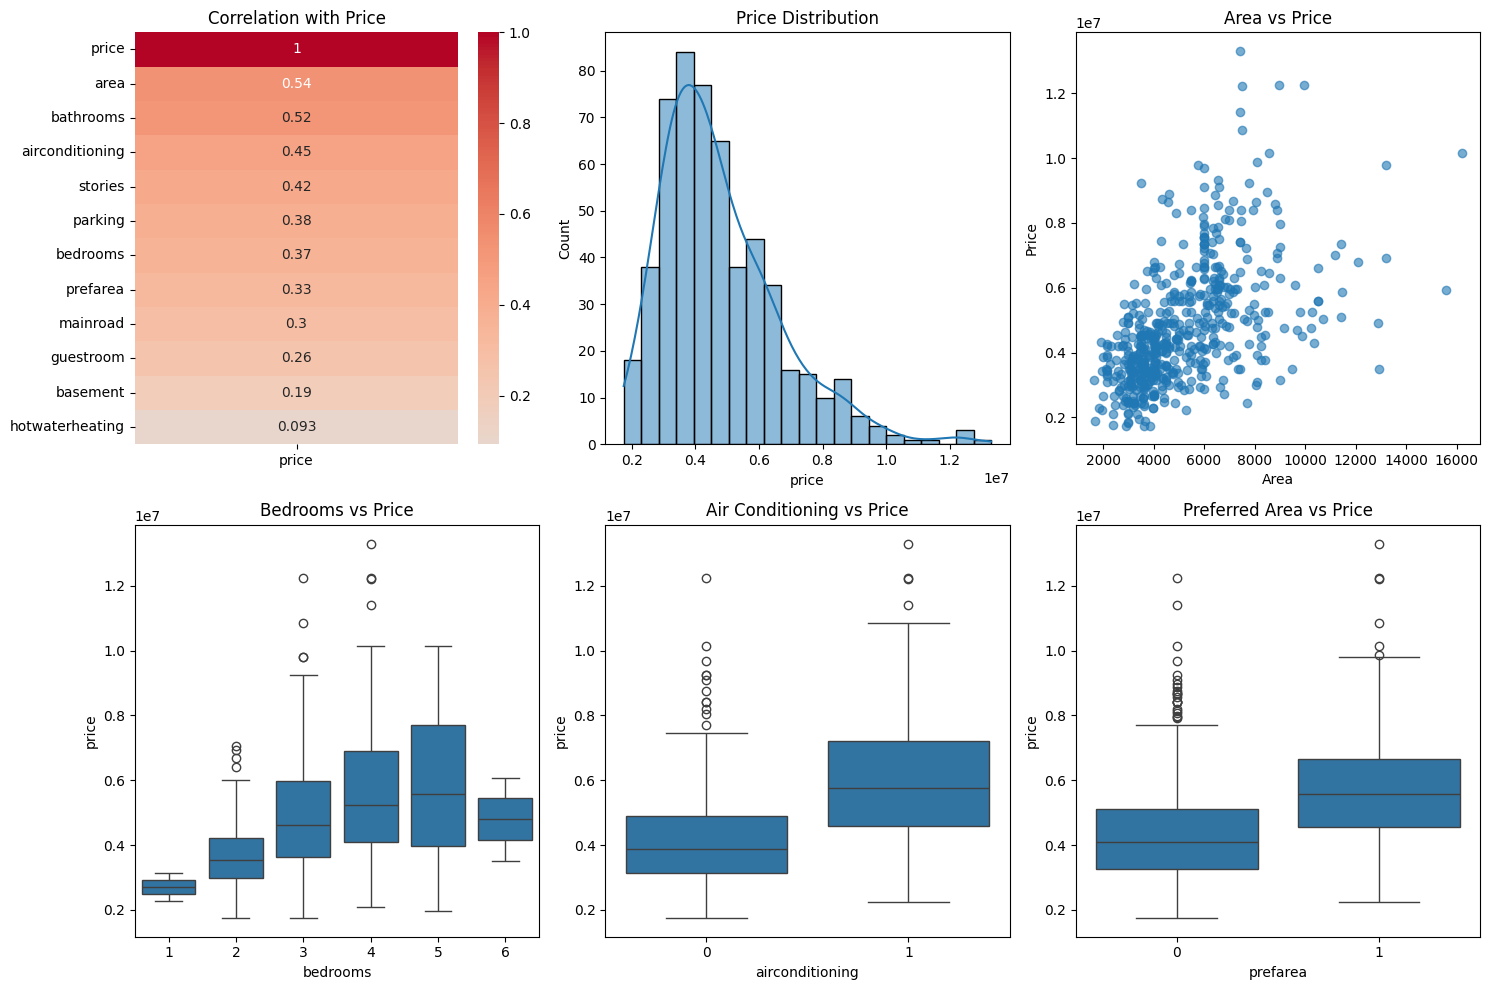

In [3]:
# Exploratory Data Analysis
plt.figure(figsize=(15, 10))

# Correlation heatmap
plt.subplot(2, 3, 1)
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix[['price']].sort_values(by='price', ascending=False), 
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlation with Price')

# Price distribution
plt.subplot(2, 3, 2)
sns.histplot(df['price'], kde=True)
plt.title('Price Distribution')

# Area vs Price
plt.subplot(2, 3, 3)
plt.scatter(df['area'], df['price'], alpha=0.6)
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Area vs Price')

# Bedrooms vs Price
plt.subplot(2, 3, 4)
sns.boxplot(x='bedrooms', y='price', data=df)
plt.title('Bedrooms vs Price')

# Air conditioning impact
plt.subplot(2, 3, 5)
sns.boxplot(x='airconditioning', y='price', data=df)
plt.title('Air Conditioning vs Price')

# Preferred area impact
plt.subplot(2, 3, 6)
sns.boxplot(x='prefarea', y='price', data=df)
plt.title('Preferred Area vs Price')

plt.tight_layout()
plt.show()

In [4]:
# Prepare features and target variable
X = df.drop('price', axis=1)
y = df['price']

print("Feature matrix shape:", X.shape)
print("Target variable shape:", y.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Feature matrix shape: (545, 14)
Target variable shape: (545,)
Training set: 436 samples
Testing set: 109 samples


In [5]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=== MODEL EVALUATION ===")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:,.2f}")
print(f"Mean Squared Error: {mse:,.2f}")
print(f"Root Mean Squared Error: {rmse:,.2f}")

# Calculate percentage errors
percentage_errors = np.abs((y_test - y_pred) / y_test) * 100
mean_percentage_error = np.mean(percentage_errors)
print(f"Mean Absolute Percentage Error: {mean_percentage_error:.2f}%")

=== MODEL EVALUATION ===
R² Score: 0.6529
Mean Absolute Error: 970,043.40
Mean Squared Error: 1,754,318,687,330.67
Root Mean Squared Error: 1,324,506.96
Mean Absolute Percentage Error: 21.04%



=== FEATURE IMPORTANCE ===
                      feature     importance
2                   bathrooms  521879.027748
0                        area  519552.416340
8             airconditioning  365157.393851
3                     stories  349251.438906
10                   prefarea  266656.351993
9                     parking  192005.953667
6                    basement  187067.803214
7             hotwaterheating  149862.702991
4                    mainroad  128498.628215
13     furnishing_unfurnished  106204.104713
5                   guestroom   88768.667686
11       furnishing_furnished   80529.382918
1                    bedrooms   57349.559419
12  furnishing_semi-furnished   28712.175946


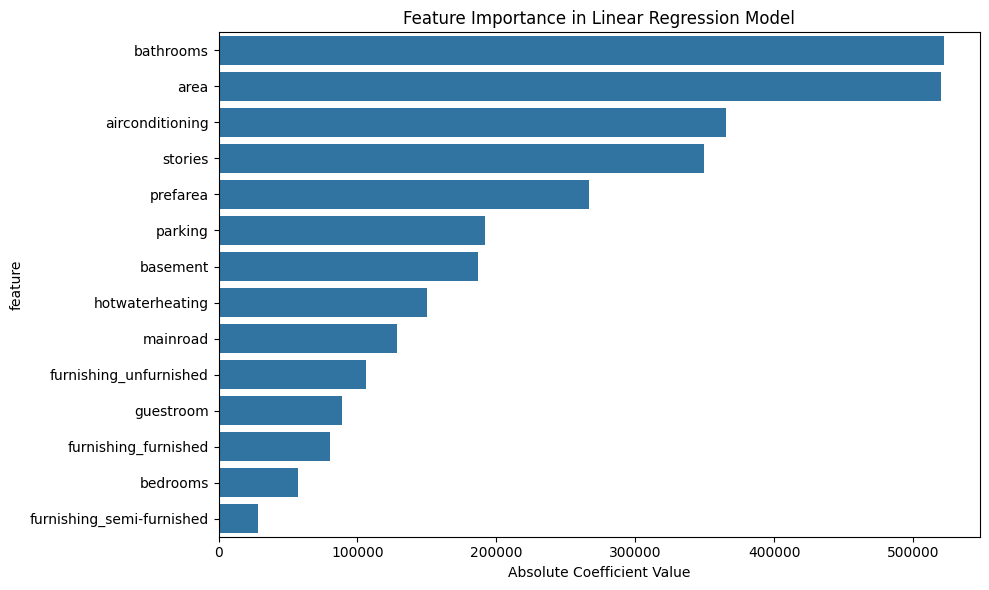

In [6]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': abs(model.coef_)
}).sort_values('importance', ascending=False)

print("\n=== FEATURE IMPORTANCE ===")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance in Linear Regression Model')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

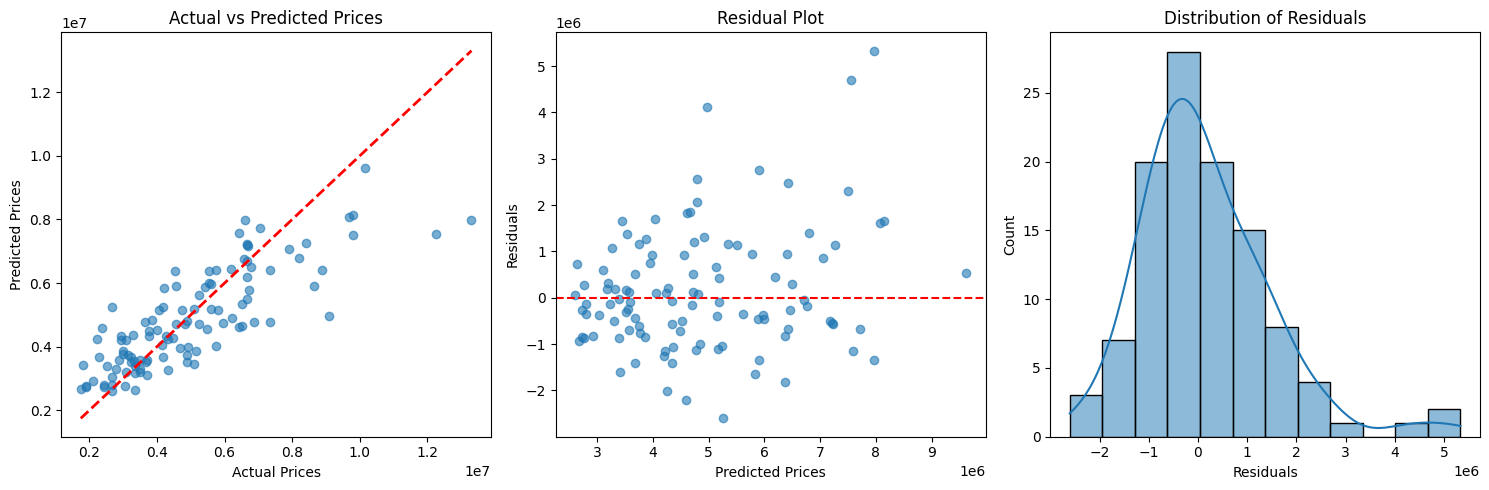

In [7]:
# Visualization of predictions vs actual values
plt.figure(figsize=(15, 5))

# Predictions vs Actual
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')

# Residual plot
plt.subplot(1, 3, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Error distribution
plt.subplot(1, 3, 3)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')

plt.tight_layout()
plt.show()

In [8]:
# Model interpretation and sample predictions
print("\n=== MODEL INTERPRETATION ===")
print("Model coefficients (scaled features):")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature:20}: {coef:12.2f}")

print(f"\nIntercept: {model.intercept_:.2f}")

# Sample predictions with interpretation
sample_idx = np.random.randint(0, len(X_test), 5)
print("\n=== SAMPLE PREDICTIONS ===")
for idx in sample_idx:
    actual = y_test.iloc[idx]
    predicted = y_pred[idx]
    error = abs(actual - predicted)
    error_percent = (error / actual) * 100
    
    print(f"\nActual Price: {actual:,.2f}")
    print(f"Predicted Price: {predicted:,.2f}")
    print(f"Absolute Error: {error:,.2f} ({error_percent:.1f}%)")


=== MODEL INTERPRETATION ===
Model coefficients (scaled features):
area                :    519552.42
bedrooms            :     57349.56
bathrooms           :    521879.03
stories             :    349251.44
mainroad            :    128498.63
guestroom           :     88768.67
basement            :    187067.80
hotwaterheating     :    149862.70
airconditioning     :    365157.39
parking             :    192005.95
prefarea            :    266656.35
furnishing_furnished:     80529.38
furnishing_semi-furnished:     28712.18
furnishing_unfurnished:   -106204.10

Intercept: 4706527.39

=== SAMPLE PREDICTIONS ===

Actual Price: 5,530,000.00
Predicted Price: 5,998,642.37
Absolute Error: 468,642.37 (8.5%)

Actual Price: 8,890,000.00
Predicted Price: 6,420,308.27
Absolute Error: 2,469,691.73 (27.8%)

Actual Price: 3,325,000.00
Predicted Price: 3,557,571.07
Absolute Error: 232,571.07 (7.0%)

Actual Price: 3,500,000.00
Predicted Price: 3,584,359.56
Absolute Error: 84,359.56 (2.4%)

Actual Price:

In [9]:
# Advanced analysis: Model performance by price ranges
def analyze_performance_by_range(y_true, y_pred):
    df_results = pd.DataFrame({
        'actual': y_true,
        'predicted': y_pred,
        'error': abs(y_true - y_pred),
        'error_percent': (abs(y_true - y_pred) / y_true) * 100
    })
    
    # Create price ranges
    df_results['price_range'] = pd.cut(df_results['actual'], 
                                     bins=[0, 4000000, 6000000, 8000000, 10000000, 15000000],
                                     labels=['<4M', '4-6M', '6-8M', '8-10M', '>10M'])
    
    performance_by_range = df_results.groupby('price_range').agg({
        'error_percent': 'mean',
        'error': 'mean'
    }).round(2)
    
    return performance_by_range

performance_analysis = analyze_performance_by_range(y_test, y_pred)
print("\n=== PERFORMANCE BY PRICE RANGE ===")
print(performance_analysis)


=== PERFORMANCE BY PRICE RANGE ===
             error_percent       error
price_range                           
<4M                  27.94   735072.69
4-6M                 15.32   747115.90
6-8M                 14.62   986830.99
8-10M                24.04  2178726.33
>10M                 27.89  3519786.72


In [10]:
# Final model summary and business insights
print("=== MODEL SUMMARY & BUSINESS INSIGHTS ===")
print(f"1. Model Performance: R² = {r2:.3f} ({(r2*100):.1f}% of price variance explained)")
print(f"2. Average Prediction Error: ₹{mae:,.2f} ({mean_percentage_error:.1f}% of actual price)")

print("\n3. Key Price Drivers (Top 5):")
top_features = feature_importance.head(5)
for _, row in top_features.iterrows():
    print(f"   - {row['feature']}: Coefficient = {row['importance']:.2f}")

print("\n4. Business Recommendations:")
print("   - Focus on properties with larger area and more bedrooms")
print("   - Air conditioning and preferred location significantly increase value")
print("   - Furnished properties command higher prices")
print("   - Basements and guest rooms add moderate value")

# Save the model and preprocessing objects
import joblib
model_artifacts = {
    'model': model,
    'scaler': scaler,
    'feature_names': X.columns.tolist()
}

joblib.dump(model_artifacts, 'house_price_model.pkl')
print("\nModel artifacts saved as 'house_price_model.pkl'")

=== MODEL SUMMARY & BUSINESS INSIGHTS ===
1. Model Performance: R² = 0.653 (65.3% of price variance explained)
2. Average Prediction Error: ₹970,043.40 (21.0% of actual price)

3. Key Price Drivers (Top 5):
   - bathrooms: Coefficient = 521879.03
   - area: Coefficient = 519552.42
   - airconditioning: Coefficient = 365157.39
   - stories: Coefficient = 349251.44
   - prefarea: Coefficient = 266656.35

4. Business Recommendations:
   - Focus on properties with larger area and more bedrooms
   - Air conditioning and preferred location significantly increase value
   - Furnished properties command higher prices
   - Basements and guest rooms add moderate value

Model artifacts saved as 'house_price_model.pkl'
